In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
df = pd.read_csv('Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.tail(10)

C:\Users\nn\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,narrative,Product
2867701,Caliber Home Loans ( CHL ) sent confirmation i...,Mortgage
2867702,Received cease and desist letter from them sho...,Debt collection
2867704,A reward coupon from XXXX expired and American...,Credit card
2867705,Wrong name no XXXX XXXX XXXX and wrong address...,Credit reporting
2867706,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,Consumer Loan
2867707,"Automated calls from "" XXXX with Capital One '...",Credit card
2867708,I have disputed my debts several times with no...,Debt collection
2867709,My father died in XX/XX/XXXX. Left me his only...,Mortgage
2867710,My husband and I are in the middle of an FHA S...,Credit reporting
2867711,cfbp i would Like to file a complaint on Exper...,Credit reporting


In [16]:
from gensim.models import Doc2Vec

In [17]:
df.head(100)

,narrative,Product
10,According to 15 USC 1681 ( a ) ( 4 ) There is ...,"Credit reporting, credit repair services, or o..."
16,The cable/internet company XXXX XXXX has attac...,Debt collection
22,I had traveled to illinois to buy a couch that...,Checking or savings account
23,I am writing to delete the following informati...,"Credit reporting, credit repair services, or o..."
26,I have disputed the referenced accounts to the...,"Credit reporting, credit repair services, or o..."
...,...,...
291,I am writing to you due to Huntington bank in ...,Debt collection
292,"My husband and I bank with XXXX, but our car l...",Vehicle loan or lease
296,I received the following email from a company ...,Debt collection
300,After recently signing up for a credit monitor...,"Credit reporting, credit repair services, or o..."


In [18]:
dff = df.iloc[
    0:10000,
]


In [19]:
text_corpus = dff.values.tolist()
node_subjects = []
for i in range(len(text_corpus)):
    node_subjects.append(text_corpus[i][1])
    i = i+1
print(node_subjects[9999])

Credit reporting, credit repair services, or other personal consumer reports


In [20]:
dff.shape

(10000, 2)

In [21]:
dff.index = range(10000)
dff['narrative'].apply(lambda x: len(x.split(' '))).sum()

1931759

C:\Users\nn\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


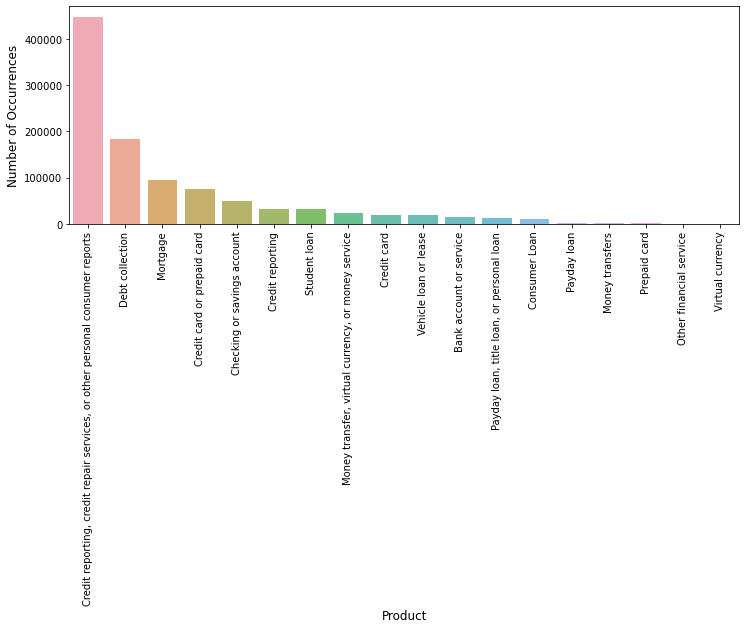

In [22]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [23]:
def print_complaint(index):
    example = dff[dff.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_complaint(9)

Been getting these texts almost daily regarding my BOA account
Product: Credit card or prepaid card


In [24]:
print_complaint(1000)

XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX In accordance with the Fair Credit Reporting act XXXX XXXX XXXX XXXX has violated my rights. 

15 U.S.C 1681 section 602 A. States I have the right to privacy.

15 U.S.C 1681 Section 604 A Section 2 : It also states a consumer reporting agency can not furnish a account without my written instructions
Product: Credit reporting, credit repair services, or other personal consumer reports


In [25]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
dff['narrative'] = dff['narrative'].apply(cleanText)

C:\Users\nn\AppData\Local\Temp/ipykernel_12684/3701831749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['narrative'] = dff['narrative'].apply(cleanText)


In [26]:
j = 0
for i in text_corpus:
    text_corpus[j] = i[0] +" " + i[1] 
    text_corpus[j] = re.split('; |, |' ' |\n', text_corpus[j])
    j = j + 1


In [27]:
print(text_corpus[1])
print(len(text_corpus))

['The', 'cable/internet', 'company', 'XXXX', 'XXXX', 'has', 'attached', 'an', 'account', 'in', 'collections', 'that', 'is', 'not', 'mine', 'but', 'belonged', 'to', 'a', 'previous', 'resident', 'at', 'my', 'former', 'address.', 'My', 'account', 'is', 'current.', 'They', 'refuse', 'to', 'remove', 'the', 'delinquent', 'account', 'off', 'my', 'credit', 'report', 'because', 'my', 'former', 'address', 'was', 'the', 'same', 'as', 'the', 'other', 'account.', 'Debt', 'collection']
10000


In [28]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

def tagged_document(lis_of_list_of_words):
    for i, list_of_words in enumerate(lis_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

data_for_training = list(tagged_document(text_corpus))   
print(data_for_training[100])


TaggedDocument(['My', 'name', 'is', 'XXXX', 'XXXX', 'XXXX', 'and', 'I', 'am', 'sending', 'this', 'request', 'myself', 'to', 'address', 'the', 'inaccuracies', 'on', 'my', 'Credit', 'Reports.', 'These', 'accounts', 'are', 'inaccurately', 'and', 'erroneously', 'reporting.', 'Their', 'intentional', 'and', 'willful', 'furnishing', 'of', 'inaccurate', 'information', 'is', 'a', 'violation', 'of', 'FCRA', 'Section', '623', 'and', 'according', 'to', 'FCRA', 'Section', '611.', 'I', 'have', 'done', 'many', 'attempts', 'to', 'reach', 'out', 'to', '3', 'Credit', 'Bureaus', 'but', 'they', 'failed', 'to', 'give', 'me', 'any', 'results', 'or', 'feedbacks', 'about', 'this', 'concern.', 'Please', 'investigate', 'and', 'remove', 'them', 'from', 'my', 'personal', 'credit', 'file.', 'Thank', 'you.', '', '', 'ARS', 'ACCOUNT', 'RESOLUTION', '(', 'Original', 'creditor', ':', 'XXXX', 'XXXX', 'XXXX', 'XXXX', ')', 'XXXX', 'Balance', '{$710.00}', '', 'ARS', 'ACCOUNT', 'RESOLUTION', '(', 'Original', 'creditor', ':

In [29]:
data_for_training[9999]

TaggedDocument(words=['in', 'accordance', 'with', 'the', 'Fair', 'Credit', 'Reporting', 'act', 'XXXX', 'XXXX', 'XXXX', 'Account', '#', 'XXXX', 'XXXX', 'XXXX', 'Account', '#', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'Account', '#', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'Account', '#', 'XXXX', 'XXXX', 'XXXX', '', 'Account', '#', 'XXXXXXXX', 'XXXX', 'XXXX', '', 'Account', '#', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'Account', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXXXXXX', 'Account', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'Account', '#', 'XXXX', 'XXXX', 'XXXX', 'bankruptcy', 'discharged', 'Account', '#', 'XXXX', 'XXXX', 'Account', '#', 'XXXX', 'has', 'violated', 'my', 'rights.', '', '', '15', 'U.S.C', '1681', 'section', '602', 'A.', 'States', 'I', 'have', 'the', 'right', 'to', 'privacy.', '', '15', 'U.S.C', '1681', 'Section', '604', 'A', 'Section', '2', ':', 'It', 'also', 'states', 'a', 'consumer', 'reporting', 'agency', 'can', 'not', 'furnish', 'a', 'account', 'without', 'my', 'w

In [30]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=40)
model.build_vocab(data_for_training)

In [31]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
model.save("doc2vec15.model")

In [32]:
# Load pre-trained Word2Vec model.
import gensim
model = gensim.models.Word2Vec.load("doc2vec15.model")

In [33]:
model.dv.most_similar(9999)

[(226, 0.956283450126648),
 (8521, 0.9562066793441772),
 (2140, 0.9560589790344238),
 (2561, 0.9519822001457214),
 (4531, 0.9508881568908691),
 (4296, 0.9498310089111328),
 (8255, 0.9491985440254211),
 (461, 0.948610782623291),
 (1152, 0.9472863674163818),
 (3551, 0.9472144246101379)]

In [34]:
vector = model.dv
model.dv[142].shape

(30,)

In [35]:
len(vector)

10000

In [36]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.dv.index_to_key  # list of node IDs
node_embeddings = (
    model.dv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects

In [37]:
# Apply t-SNE transformation on node embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

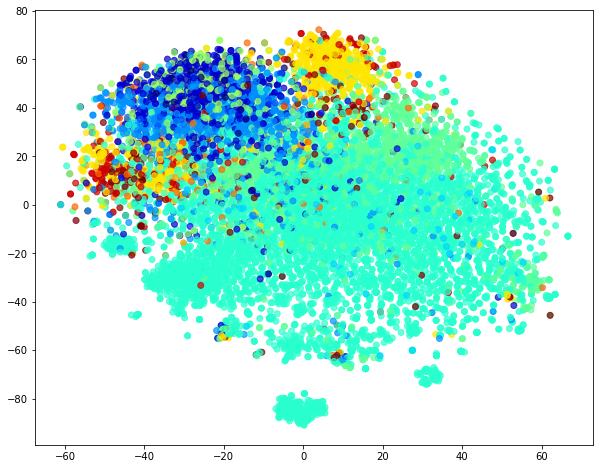

In [38]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [39]:
X = node_embeddings
X[1:100]


array([[-1.176674  ,  0.10438498,  0.68111265, ..., -0.25135735,
        -0.49001884,  0.22179444],
       [ 0.26898947, -1.0400951 ,  0.65299976, ..., -2.5997443 ,
         2.7850945 , -0.34817892],
       [-1.2881912 , -0.898736  ,  0.38086146, ...,  0.00845359,
         1.700353  , -0.8762949 ],
       ...,
       [ 0.67418385,  1.7068913 ,  1.478478  , ...,  2.074036  ,
        -2.212291  , -2.6636014 ],
       [-0.78362256, -1.3592666 ,  0.96851903, ...,  1.5572424 ,
        -0.08659527, -0.28399318],
       [-0.32860106, -0.40355128,  0.45847094, ..., -1.4838521 ,
         3.3305833 , -0.42444298]], dtype=float32)

In [40]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)


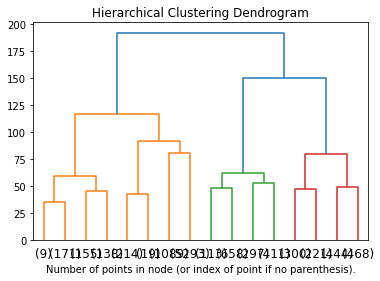

In [41]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [42]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=25, n_clusters=None)

model = model.fit(X)

In [43]:
labels = model.labels_.tolist()
nocluster = set(labels)
totalcluster = len(nocluster)
totalcluster

69

In [44]:
cluster_dict = {}

i = 0
for i in range(len(labels)):
    if labels[i] not in cluster_dict.keys():
         cluster_dict[labels[i]] = [i]
    else:
          cluster_dict[labels[i]].append(i)
    i+=1

In [45]:
vb = []
X[cluster_dict[0]]
cluster_dict[0]
X[[5, 88, 22]]

array([[-0.09775077, -0.79873246,  0.14578001,  1.3050357 ,  1.2518677 ,
         0.7721472 , -2.8408978 ,  2.2634802 ,  1.2244384 ,  0.33105013,
         3.4586363 , -0.24585731, -2.927011  , -1.7609154 , -3.171609  ,
        -1.2839873 , -0.8927612 ,  2.0357683 , -1.9034214 ,  0.29809427,
        -0.7183202 ,  0.60598314, -1.0617278 ,  3.3542106 ,  0.22666639,
         0.34523705, -0.04629089, -3.884128  , -1.9131294 , -1.793199  ],
       [-1.4885789 ,  0.18883415,  0.64045995,  0.7415279 , -1.4845209 ,
        -0.572356  ,  0.03321171,  0.37735945, -0.02360157,  1.2912192 ,
         1.5774293 , -1.1846126 ,  1.9997818 , -1.5229107 , -1.5333154 ,
        -0.22124578, -1.9460473 , -1.3341365 , -0.15745923, -0.09380876,
         0.01561841, -0.97240674,  0.25754336,  1.7234033 ,  1.7604737 ,
         0.10449619, -0.54004794, -0.03896714, -0.10680974,  0.11095611],
       [ 1.1680813 , -1.096969  ,  0.76940954, -0.98452294, -0.10471544,
        -1.5786976 , -0.43117455,  0.04849751, -1

In [46]:
X[9999]

array([-0.6107267 , -0.7347156 ,  1.163862  ,  1.1018506 ,  0.23388189,
       -0.06065958, -0.5562319 , -1.3730056 , -1.4196414 ,  1.337551  ,
        1.4557856 , -0.61497724,  1.004181  , -1.1564411 , -0.42279255,
       -1.6763858 , -0.1079988 ,  0.33472615, -1.1748519 ,  0.8498914 ,
       -0.03951547, -0.8420504 , -0.83231944,  1.1065885 ,  0.75372595,
        1.0169653 ,  0.21424976, -0.49752766,  0.7094557 , -0.85866296],
      dtype=float32)

In [47]:
for i in range(totalcluster):
    print(len(cluster_dict[i]))

178
131
241
152
77
113
151
118
195
478
86
12
327
166
196
113
35
286
101
58
76
70
55
234
59
93
133
395
97
84
55
891
149
71
72
114
920
345
66
119
57
287
60
214
65
18
110
235
41
226
65
13
174
115
7
19
25
382
90
52
5
1
59
56
90
69
105
9
39


In [48]:
outlier_cluster = []
for i in range(totalcluster):
    if len(cluster_dict[i]) <= 2:
        outlier_cluster.append(i)
    
print(outlier_cluster)

[61]


In [49]:
X[cluster_dict[outlier_cluster[0]]]

array([[ 1.2731705e+01, -5.2711719e-01,  4.1072865e+00,  1.5743387e+00,
        -3.5452852e+00, -1.1118387e+01,  4.1835680e+00, -2.5228465e+00,
        -9.6076918e+00,  3.1859138e+00,  3.0585468e+00,  4.6825713e-01,
        -2.0878189e+00,  8.2530701e-01, -6.9199142e+00,  2.5971029e-03,
         8.7346107e-01,  7.0497721e-01, -4.0649581e+00, -7.7899585e+00,
        -4.3670707e+00, -3.9286511e+00, -2.7452929e+00,  7.6946988e+00,
        -6.8947279e-01, -3.3910983e+00,  2.0365937e+00,  1.1096656e+01,
         2.0388353e+00, -4.5970755e+00]], dtype=float32)

In [50]:
cluster_dict[outlier_cluster[0]]


[7980]

In [51]:
print_complaint(3157)

on //, i purchased a mattress from   order #  online using my syncrony/paypal account  on or near //, the mattress was delivered and refused by me and cancelled the order due to unforeseen circumstances. the merchant gladly accept the return and full refund as their policy stated. paypal entered the refund on my account statement and never adjusted the outstanding balance on my paypal account. i have disputed this with , they said they have been trying to submit a refund but paypal kept rejecting it. i spoke with the team leader division and paypal. paypal states the purchase is not cover under their buyer protection. after several disputes, now paypal says i still owe the outstanding balance of  and charged an ecessive amount of fees and finance charges which i do not owe. they are in direct ftc and cfpb violation of not accepting and crediting a refund from a merchant for a returned item. here is a breakdown of the statements i received. //  {$1100.00}. //  {$1100.00}. //  {$1100.00}

In [52]:
print_complaint(4434)

hi i am submitting this   this isn't any influence and this is not a third party.  has low and unfair credit number for me in their report. i have complained. the problem has not been resolved. my fico has me at a credit score over 719 has me at a score around 590. that is a huge difference.  paints me as a . my fico say i have good credit. what the heck is going on here. i have almost no debt and my identity was stolen causing my score to drop n i made this clear for 60 days straight with   i spoke to a representative agent name  and  and  from the fraud department i prefer to speak to a us rept but they refused they had me on mute for 4 hours which was hurtful i have a perfect repayment record. i have very low credit utilization. i have three negative credit items outstanding debt now. i have modest but ok income. social security. something is wrong with . i do not understand why they are abusing consumers .this was a fist step towards attempting resolution. they kept lying telling m

In [53]:
cluster_mean = np.zeros((totalcluster, vector[1].size))

for i in range(totalcluster):
    cluster_mean[i] = np.mean(X[cluster_dict[i]], axis=0)
    


In [54]:
cluster_mean[2]
X[cluster_dict[28][1]]

array([-2.6509032 , -0.8206096 ,  0.8843706 ,  1.5643063 ,  3.4132118 ,
       -0.25439712,  2.288505  ,  1.3093865 , -1.8891338 ,  2.2746434 ,
        3.1894362 , -0.22060399,  1.5627756 , -1.1401205 , -1.6823992 ,
       -2.6967058 ,  0.05351621,  1.7357885 , -0.07706573, -2.0723524 ,
       -1.6323171 ,  0.37514117, -1.7023729 , -0.08286466, -0.65157115,
       -0.6882163 ,  1.8625783 , -0.78824973, -0.33323935,  2.7674901 ],
      dtype=float32)

In [55]:
from scipy.spatial import distance
cluster_distance = []
for i in range(totalcluster):
    if i == outlier_cluster[0]:
        continue
    cluster_distance.append((distance.euclidean(cluster_mean[outlier_cluster[0]], cluster_mean[i]),outlier_cluster[0], i))
cluster_distance

[(28.605989671557943, 61, 0),
 (28.514920240514808, 61, 1),
 (28.367212450670984, 61, 2),
 (29.110188499059984, 61, 3),
 (29.030692976224966, 61, 4),
 (28.33464694583506, 61, 5),
 (29.437771251477074, 61, 6),
 (29.132352559776894, 61, 7),
 (28.810229343779252, 61, 8),
 (28.245204664466844, 61, 9),
 (28.867189605192745, 61, 10),
 (28.55018408377265, 61, 11),
 (28.390727646401135, 61, 12),
 (29.49314042405773, 61, 13),
 (28.35831457915681, 61, 14),
 (28.44154374501159, 61, 15),
 (27.640626448020207, 61, 16),
 (28.699303686661395, 61, 17),
 (28.074638079304883, 61, 18),
 (27.876966326155745, 61, 19),
 (28.303606739123044, 61, 20),
 (29.068182294595474, 61, 21),
 (28.167955991519758, 61, 22),
 (28.19011116291951, 61, 23),
 (27.887731690335603, 61, 24),
 (28.385517875641742, 61, 25),
 (28.58448599881413, 61, 26),
 (28.744502314419737, 61, 27),
 (27.832378437850238, 61, 28),
 (28.57310760872381, 61, 29),
 (29.262026284734507, 61, 30),
 (28.47514136049866, 61, 31),
 (28.160832383208838, 61, 3

In [56]:
cluster_distance.sort(key=lambda y: y[0])
cluster_distance[:5]

[(22.927608725550012, 61, 51),
 (27.346907459735064, 61, 56),
 (27.50763488066084, 61, 45),
 (27.640626448020207, 61, 16),
 (27.832378437850238, 61, 28)]

In [57]:
k_nearest_cluster = list(zip(*cluster_distance[:5]))[2]
k_nearest_cluster

(51, 56, 45, 16, 28)

In [58]:
def findNearestObjectOfClusters(k_nearest_cluster):
    distance_all_cluster = []
    nearestObjects = []
    object_distance = []
    for j in range(len(k_nearest_cluster)):
        for i in range(len(cluster_dict[k_nearest_cluster[j]])):
            object_distance.append((distance.euclidean(cluster_mean[outlier_cluster[0]], X[cluster_dict[k_nearest_cluster[j]][i]]),outlier_cluster[0], k_nearest_cluster[j],  cluster_dict[k_nearest_cluster[j]][i]))
        #distance_all_cluster.append(object_distance)
        nearestObjects.append(min(object_distance, key=lambda tup: tup[0]))
        object_distance = []
    return  nearestObjects   

In [59]:
nearestObjects = findNearestObjectOfClusters(k_nearest_cluster)
nearestObjects.sort(key=lambda y: y[0])
nearestObjects

[(19.11018519800526, 61, 51, 3890),
 (25.55900882920485, 61, 56, 363),
 (26.05838076506028, 61, 28, 2435),
 (26.067168120778202, 61, 16, 4513),
 (26.554455511324385, 61, 45, 3569)]

In [63]:
def findCandidateObjectOfClusters(k_nearest_objects):
    closestObject = k_nearest_objects[0][3]
    closestDistance = k_nearest_objects[1][0]
    candidateObjects = []
    candidateObjects.append(k_nearest_objects[0])
    for j in range(len(k_nearest_objects)):
        #if j == 0: continue
        dist = distance.euclidean(X[closestObject], X[k_nearest_objects[j][3]])
        print(dist)
        if dist  <=  closestDistance :
            candidateObjects.append(k_nearest_objects[j])
    return  candidateObjects   

In [64]:
neighborObjects = findCandidateObjectOfClusters(nearestObjects)
neighborObjects

0.0
14.332052230834961
11.828533172607422
13.803624153137207
12.626638412475586


[(19.11018519800526, 61, 51, 3890),
 (19.11018519800526, 61, 51, 3890),
 (25.55900882920485, 61, 56, 363),
 (26.05838076506028, 61, 28, 2435),
 (26.067168120778202, 61, 16, 4513),
 (26.554455511324385, 61, 45, 3569)]

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10, centers=3, n_features=2,random_state=0)